# TensorFlow Tutorial #08
# Transfer Learning

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

We saw in the previous Tutorial #07 how to use the pre-trained Inception model for classifying images. Unfortunately the Inception model seemed unable to classify images of people. The reason was the data-set used for training the Inception model, which had some confusing text-labels for classes.

The Inception model is actually quite capable of extracting useful information from an image. So we can instead train the Inception model using another data-set. But it takes several weeks using a very powerful and expensive computer to fully train the Inception model on a new data-set.

We can instead re-use the pre-trained Inception model and merely replace the layer that does the final classification. This is called Transfer Learning.

This tutorial builds on the previous tutorials so you should be familiar with Tutorial #07 on the Inception model, as well as earlier tutorials on how to build and train Neural Networks in TensorFlow. A part of the source-code for this tutorial is located in the `inception.py` file.

## Flowchart

The following chart shows how the data flows when using the Inception model for Transfer Learning. First we input and process an image with the Inception model. Just prior to the final classification layer of the Inception model, we save the so-called Transfer Values to a cache-file.

The reason for using a cache-file is that it takes a long time to process an image with the Inception model. My laptop computer with a Quad-Core 2 GHz CPU can process about 3 images per second using the Inception model. If each image is processed more than once then we can save a lot of time by caching the transfer-values.

The transfer-values are also sometimes called bottleneck-values, but that is a confusing term so it is not used here.

When all the images in the new data-set have been processed through the Inception model and the resulting transfer-values saved to a cache file, then we can use those transfer-values as the input to another neural network. We will then train the second neural network using the classes from the new data-set, so the network learns how to classify images based on the transfer-values from the Inception model.

In this way, the Inception model is used to extract useful information from the images and another neural network is then used for the actual classification.

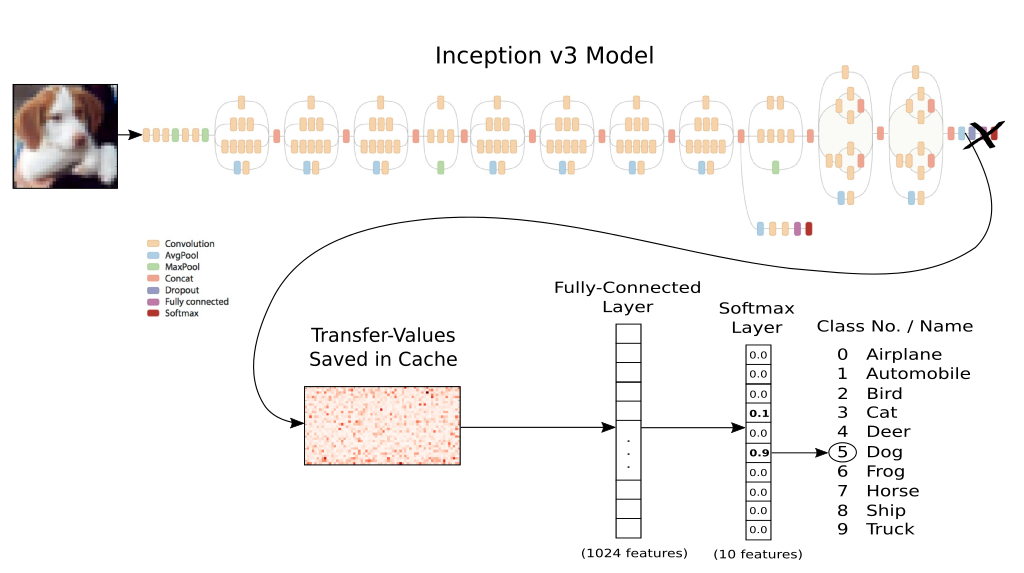

In [1]:
from IPython.display import Image, display
Image('images/08_transfer_learning_flowchart.png')

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

# Functions and classes for loading and using the Inception model.
import inception

# We use Pretty Tensor to define the new classifier.
#import prettytensor as pt

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [2]:
tf.__version__

'1.2.1'

PrettyTensor version:

In [4]:
#pt.__version__

'0.7.1'

## Load Data for CIFAR-10 

In [3]:
import cifar10

The data dimensions have already been defined in the cifar10 module, so we just need to import the ones we need.

In [4]:
from cifar10 import num_classes

Set the path for storing the data-set on your computer.

In [5]:
cifar10.data_path = "../../_DATA/CIFAR-10/"

The CIFAR-10 data-set is about 163 MB and will be downloaded automatically if it is not located in the given path.

In [6]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Load the class-names.

In [7]:
class_names = cifar10.load_class_names()
class_names

Loading data: ../../_DATA/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Load the training-set. This returns the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [8]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: ../../_DATA/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: ../../_DATA/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: ../../_DATA/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: ../../_DATA/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: ../../_DATA/CIFAR-10/cifar-10-batches-py/data_batch_5


Load the test-set.

In [9]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: ../../_DATA/CIFAR-10/cifar-10-batches-py/test_batch


The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [10]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


### Helper-function for plotting images

Function used to plot at most 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [11]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

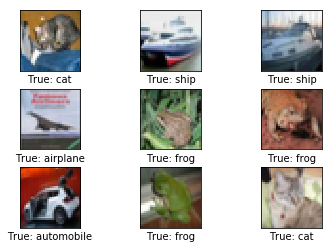

In [12]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

## Download the Inception Model

The Inception model is downloaded from the internet. This is the default directory where you want to save the data-files. The directory will be created if it does not exist.

In [13]:
inception.data_dir = '../../_DATA/inception/'

Download the data for the Inception model if it doesn't already exist in the directory. It is 85 MB.

See Tutorial #07 for more details.

In [14]:
inception.maybe_download()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


## Load the Inception Model

Load the Inception model so it is ready for classifying images.

Note the deprecation warning, which might cause the program to fail in the future.

In [15]:
model = inception.Inception()

## Calculate Transfer-Values

Import a helper-function for caching the transfer-values of the Inception model.

In [16]:
from inception import transfer_values_cache

Set the file-paths for the caches of the training-set and test-set.

In [17]:
file_path_cache_train = os.path.join(cifar10.data_path, 'inception_cifar10_train.pkl')
file_path_cache_test = os.path.join(cifar10.data_path, 'inception_cifar10_test.pkl')

In [19]:
print("Processing Inception transfer-values for training-images ...")

# Scale images because Inception needs pixels to be between 0 and 255,
# while the CIFAR-10 functions return pixels between 0.0 and 1.0
images_scaled = images_train * 255.0

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_scaled,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Processing image:  50000 / 50000
- Data saved to cache-file: ../../_DATA/CIFAR-10/inception_cifar10_train.pkl


In [20]:
print("Processing Inception transfer-values for test-images ...")

# Scale images because Inception needs pixels to be between 0 and 255,
# while the CIFAR-10 functions return pixels between 0.0 and 1.0
images_scaled = images_test * 255.0

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_scaled,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Processing image:  10000 / 10000
- Data saved to cache-file: ../../_DATA/CIFAR-10/inception_cifar10_test.pkl


Check the shape of the array with the transfer-values. There are 50,000 images in the training-set and for each image there are 2048 transfer-values.

In [21]:
transfer_values_train.shape

(50000, 2048)

Similarly, there are 10,000 images in the test-set with 2048 transfer-values for each image.

In [22]:
transfer_values_test.shape

(10000, 2048)

### Helper-function for plotting transfer-values

In [23]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    plt.imshow(images_test[i], interpolation='nearest')
    plt.show()

    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


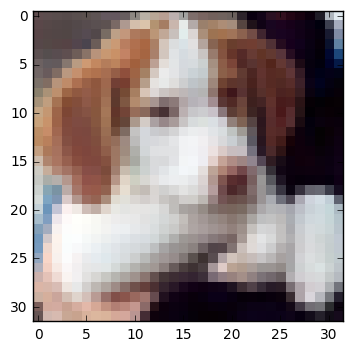

Transfer-values for the image using Inception model:


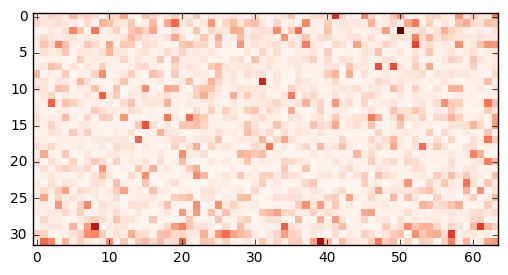

In [25]:
plot_transfer_values(i=16)

Input image:


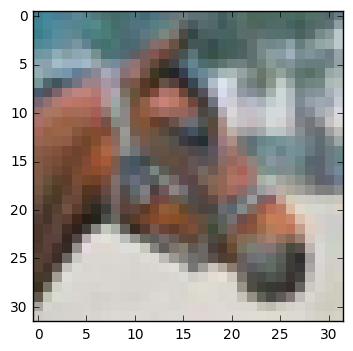

Transfer-values for the image using Inception model:


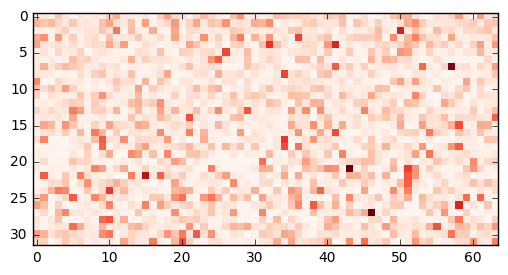

In [26]:
plot_transfer_values(i=17)

## Analysis of Transfer-Values using PCA

Use Principal Component Analysis (PCA) from scikit-learn to reduce the array-lengths of the transfer-values from 2048 to 2 so they can be plotted.

In [24]:
from sklearn.decomposition import PCA

Create a new PCA-object and set the target array-length to 2.

In [25]:
pca = PCA(n_components=2)

It takes a while to compute the PCA so the number of samples has been limited to 3000. You can try and use the full training-set if you like.

In [26]:
transfer_values = transfer_values_train[0:3000]

Get the class-numbers for the samples you selected.

In [27]:
cls = cls_train[0:3000]

Check that the array has 3000 samples and 2048 transfer-values for each sample.

In [28]:
transfer_values.shape

(3000, 2048)

In [ ]:
## 2048 means ?

Use PCA to reduce the transfer-value arrays from 2048 to 2 elements.

In [29]:
transfer_values_reduced = pca.fit_transform(transfer_values)

Check that it is now an array with 3000 samples and 2 values per sample.

In [30]:
transfer_values_reduced.shape

(3000, 2)

Helper-function for plotting the reduced transfer-values.

In [31]:
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Get the color for each sample.
    colors = cmap[cls]

    # Extract the x- and y-values.
    x = values[:, 0]
    y = values[:, 1]

    # Plot it.
    plt.scatter(x, y, color=colors)
    plt.show()

Plot the transfer-values that have been reduced using PCA. There are 10 different colors for the different classes in the CIFAR-10 data-set. The colors are grouped together but with very large overlap. This may be because PCA cannot properly separate the transfer-values.

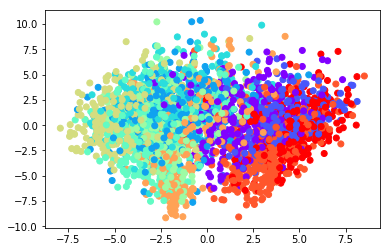

In [32]:
plot_scatter(transfer_values_reduced, cls)

## Analysis of Transfer-Values using t-SNE

In [33]:
from sklearn.manifold import TSNE

Another method for doing dimensionality reduction is t-SNE. Unfortunately, t-SNE is very slow so we first use PCA to reduce the transfer-values from 2048 to 50 elements.

In [34]:
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

Create a new t-SNE object for the final dimensionality reduction and set the target to 2-dim.

In [35]:
tsne = TSNE(n_components=2)

Perform the final reduction using t-SNE. The current implemenation of t-SNE in scikit-learn cannot handle data with many samples so this might crash if you use the full training-set.

In [36]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

Check that it is now an array with 3000 samples and 2 transfer-values per sample.

In [37]:
transfer_values_reduced.shape

(3000, 2)

Plot the transfer-values that have been reduced to 2-dim using t-SNE, which shows better separation than the PCA-plot above.

This means the transfer-values from the Inception model appear to contain enough information to separate the CIFAR-10 images into classes, although there is still some overlap so the separation is not perfect.

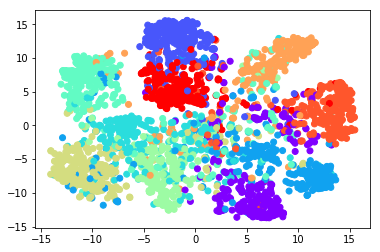

In [38]:
plot_scatter(transfer_values_reduced, cls)

In [39]:
## t-sne fully 
tsne = TSNE(n_components=2)
transfer_values_2 = tsne.fit_transform(transfer_values)
transfer_values_2.shape

(3000, 2)

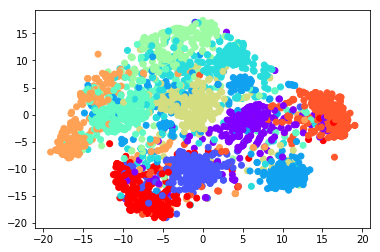

In [41]:
plot_scatter(transfer_values_2, cls)

## New Classifier in TensorFlow

Now we will create another neural network in TensorFlow. This network will take as input the transfer-values from the Inception model and output the predicted classes for CIFAR-10 images.

It is assumed that you are already familiar with how to build neural networks in TensorFlow, otherwise see e.g. Tutorial #03.

### Placeholder Variables

First we need the array-length for transfer-values which is stored as a variable in the object for the Inception model.

In [42]:
transfer_len = model.transfer_len

Now create a placeholder variable for inputting the transfer-values from the Inception model into the new network that we are building. The shape of this variable is `[None, transfer_len]` which means it takes an input array with an arbitrary number of samples as indicated by the keyword `None` and each sample has 2048 elements, equal to `transfer_len`.

In [43]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

Create another placeholder variable for inputting the true class-label of each image. These are so-called One-Hot encoded arrays with 10 elements, one for each possible class in the data-set.

In [44]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

Calculate the true class as an integer. This could also be a placeholder variable.

In [45]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Neural Network

Create the neural network for doing the classification on the CIFAR-10 data-set. This takes as input the transfer-values from the Inception model which will be fed into the placeholder variable `x`. The network outputs the predicted class in `y_pred`.

See Tutorial #03 for more details on how to use Pretty Tensor to construct neural networks.

In [46]:
# Wrap the transfer-values as a Pretty Tensor object.
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

In [ ]:
y_pred, loss = tf.layers.fully_connected(x, size=1024)

### Optimization Method

Create a variable for keeping track of the number of optimization iterations performed.

In [47]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

Method for optimizing the new neural network.

In [48]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

### Classification Accuracy

The output of the network `y_pred` is an array with 10 elements. The class number is the index of the largest element in the array.

In [49]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Create an array of booleans whether the predicted class equals the true class of each image.

In [50]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the array of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [51]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow Session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [52]:
session = tf.Session()

### Initialize Variables

The variables for the new network must be initialized before we start optimizing them.

In [53]:
session.run(tf.global_variables_initializer())

### Helper-function to get a random training-batch

There are 50,000 images (and arrays with transfer-values for the images) in the training-set. It takes a long time to calculate the gradient of the model using all these images (transfer-values). We therefore only use a small batch of images (transfer-values) in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [54]:
train_batch_size = 64

Function for selecting a random batch of transfer-values from the training-set.

In [55]:
def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

### Helper-function to perform optimization

This function performs a number of optimization iterations so as to gradually improve the variables of the neural network. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [56]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## Helper-Functions for Showing Results

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [57]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]

    n = min(9, len(images))
    
    # Plot the first n images.
    plot_images(images=images[0:n],
                cls_true=cls_true[0:n],
                cls_pred=cls_pred[0:n])

### Helper-function to plot confusion matrix

In [58]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Helper-functions for calculating classifications

This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [59]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

Calculate the predicted class for the test-set.

In [60]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for calculating the classification accuracy

This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. `classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4`. The function also returns the number of correct classifications.

In [61]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### Helper-function for showing the classification accuracy

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [62]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Results

## Performance before any optimization

The classification accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [63]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=False)

Accuracy on Test-Set: 9.4% (939 / 10000)


## Performance after 10,000 optimization iterations

After 10,000 optimization iterations, the classification accuracy is about 90% on the test-set. Compare this to the basic Convolutional Neural Network from Tutorial #06 which had less than 80% accuracy on the test-set.

In [64]:
optimize(num_iterations=10000)

Global Step:    100, Training Batch Accuracy:  82.8%
Global Step:    200, Training Batch Accuracy:  90.6%
Global Step:    300, Training Batch Accuracy:  90.6%
Global Step:    400, Training Batch Accuracy:  95.3%
Global Step:    500, Training Batch Accuracy:  85.9%
Global Step:    600, Training Batch Accuracy:  84.4%
Global Step:    700, Training Batch Accuracy:  90.6%
Global Step:    800, Training Batch Accuracy:  93.8%
Global Step:    900, Training Batch Accuracy:  92.2%
Global Step:   1000, Training Batch Accuracy:  95.3%
Global Step:   1100, Training Batch Accuracy:  93.8%
Global Step:   1200, Training Batch Accuracy:  90.6%
Global Step:   1300, Training Batch Accuracy:  95.3%
Global Step:   1400, Training Batch Accuracy:  90.6%
Global Step:   1500, Training Batch Accuracy:  90.6%
Global Step:   1600, Training Batch Accuracy:  92.2%
Global Step:   1700, Training Batch Accuracy:  90.6%
Global Step:   1800, Training Batch Accuracy:  92.2%
Global Step:   1900, Training Batch Accuracy: 

Accuracy on Test-Set: 90.7% (9069 / 10000)
Example errors:


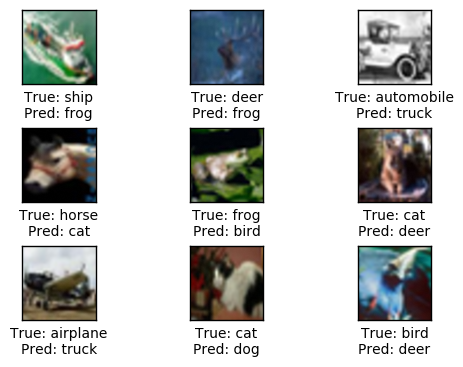

Confusion Matrix:
[926   6  13   2   3   0   1   1  29  19] (0) airplane
[  9 921   2   5   0   1   1   1   2  58] (1) automobile
[ 18   1 883  31  32   4  22   5   1   3] (2) bird
[  7   2  19 855  23  57  24   9   2   2] (3) cat
[  5   0  21  25 896   4  24  22   2   1] (4) deer
[  2   0  12  97  18 843  10  15   1   2] (5) dog
[  2   1  16  17  17   4 940   1   2   0] (6) frog
[  8   0  10  19  28  14   1 914   2   4] (7) horse
[ 42   6   1   4   1   0   2   0 932  12] (8) ship
[  6  19   2   2   1   0   1   1   9 959] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [65]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources. Note that there are two TensorFlow-sessions so we close both, one session is inside the model-object.

In [66]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# model.close()
# session.close()

## Conclusion

In the previous Tutorial #06 it took 15 hours on a laptop PC to train a neural network for classifying the CIFAR-10 data-set with an accuracy of about 80% on the test-set.

In this tutorial we used the Inception model from Tutorial #07 to achieve a classification accuracy of about 90% on the CIFAR-10 data-set. This was done by feeding all the images from the CIFAR-10 data-set through the Inception model and caching the so-called transfer-values prior to the final classification layer. We then built another neural network that took these transfer-values as input and produced a CIFAR-10 class as output.

The CIFAR-10 data-set contains a total of 60,000 images. It took about 6 hours to calculate the transfer-values of the Inception model for all these images, using a laptop PC without a GPU. And training the new classifier on top of these transfer-values only took a few minutes. So the combined time-usage of this tranfer-learning was less than half the time it took to train a neural network directly for the CIFAR-10 data-set, and it achieved significantly higher classification accuracy.

So transfer-learning with the Inception model is useful for building an image classifier for your own data-set.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook and the other files before making any changes.

* Try using the full training-set in the PCA and t-SNE plots. What happens?
* Try changing the neural network for doing the new classification. What happens if you remove the fully-connected layer, or add more fully-connected layers?
* What happens if you perform fewer or more optimization iterations?
* What happens if you change the `learning_rate` for the optimizer?
* How would you implement random distortions to the CIFAR-10 images as was done in Tutorial #06? You can no longer use the cache because each input image is different.
* Try using the MNIST data-set instead of the CIFAR-10 data-set.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.